In [1]:
#here I make some calibration to chessboard images to get some coffecient that will help to correct distoration in any
#image that will be taken by camera
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images 
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318544e-04
    2.67124303e-02]]


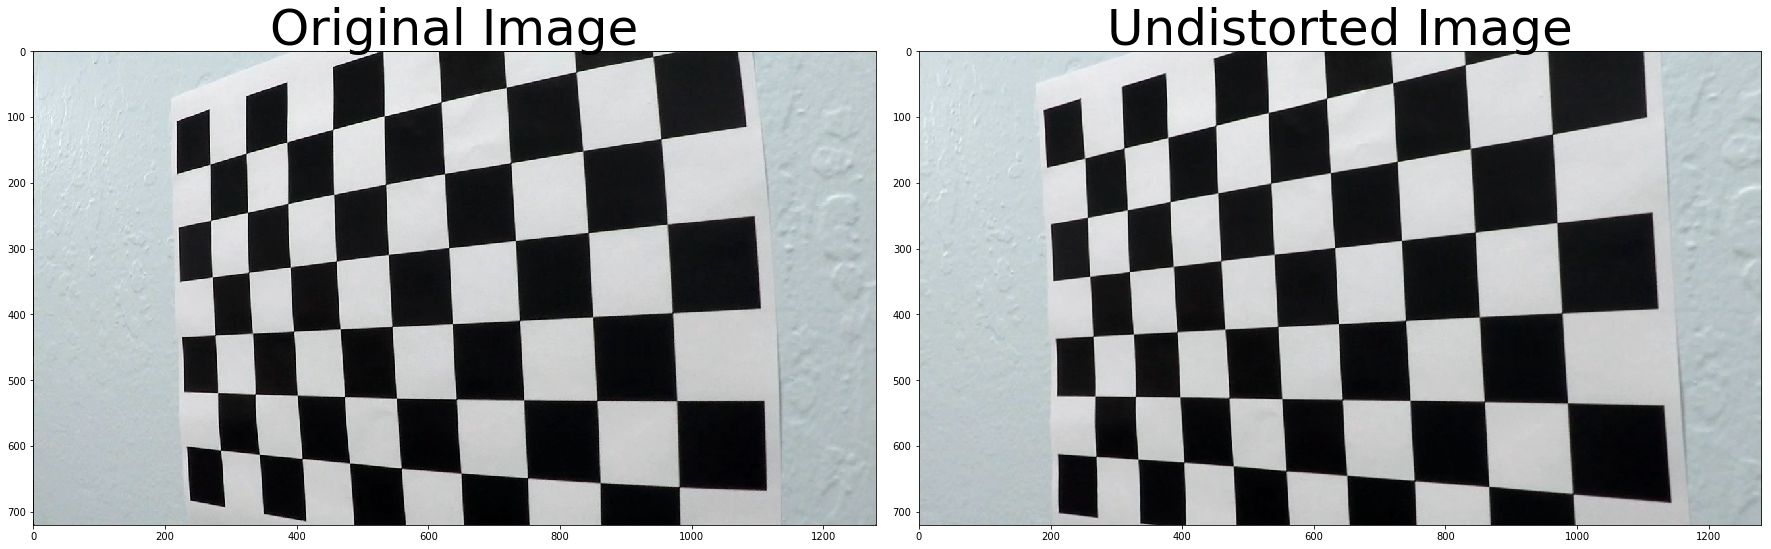

In [2]:
#this function take image form chessboards image and correct its distortion by this function cv2.undistort()
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    print(mtx)
    print(dist)
    #the two vaiables mtx1 and dist1 save numbers that I will use to correct distortion in any image
    global mtx1
    global dist1
    mtx1 = np.array(mtx)
    dist1 =  np.array(dist)
    return undist
#this function take any image and correct its distortion using coffecients from the above function 
def cal_undistort2(img):

    undist=cv2.undistort(img, mtx1, dist1, None, mtx1)

    return undist
img = cv2.imread('camera_cal/calibration4.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# abs_sobel_thresh() is function which take an image and orient (x or y) and the minumum and maxiumum threshold and return image 
# image which converted to either sobel x or sobel y according to orient
def abs_sobel_thresh(img, orient, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# mag_thresh() is function which take an image and kernel it should be odd number and the maxiumum number is 31
#and the minumum and maxiumum threshold and return image  which converted to threholded magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = img[:,:,0]

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# dir_threshold() is function which take an image and kernel it should be odd number and the maxiumum number is 31
#and the minumum and maxiumum threshold and return image  which converted to threholded direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = img[:,:,0]

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def pipeline(img, s_thresh=(170, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)#.astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary2 = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return s_binary

# hls_select() is function which take an image and the minumum and maxiumum threshold and return image with s channel
def r_select(img, thresh=(0, 255)):
    s_channel = img[:,:,0]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# hls_select() is function which take an image and the minumum and maxiumum threshold and return image with l channel
def l_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output
def h_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output
def h_hsv(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = hls[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output
def s_hsv(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output
def v_hsv(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = hls[:,:,2]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def select_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    binary_output = np.zeros_like(mask)
    binary_output[mask==255 ] = 1

    return binary_output
def select_yellow2(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,40,40])
    x=400
    upper = np.array([78+x,214+x, 290+x])
    mask = cv2.inRange(hsv, lower, upper)

    return mask

def select_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(img, lower, upper)
    binary_output = np.zeros_like(mask)
    binary_output[mask==255 ] = 1
    return binary_output


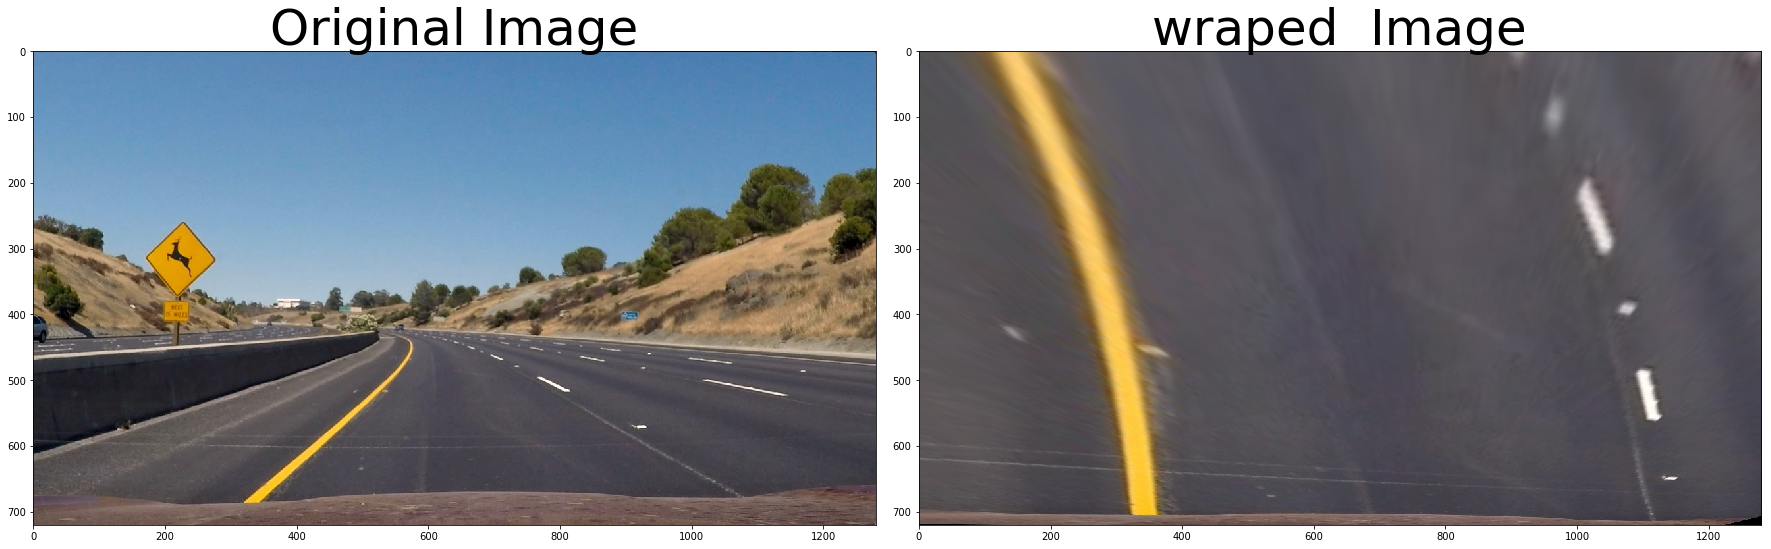

In [4]:
#corners_unwarp() takes an image and make perspective transform on image according to desired points which I defined inside 
#the function
def corners_unwarp(img):
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners  
    #src = np.float32([[549,461], [229,663], [1067,663],   [730,461]     ])
    #src = np.float32([[618 ,446], [203,701], [1000,701],   [709,448]     ])
    #src = np.float32([[630 ,446], [203,701], [1000,701],   [709,448]     ])
    #src = np.float32([[630 ,446], [253,701], [1000,701],   [709,448]     ])
    #src = np.float32([[580,448], [203,701], [1000,701],   [709,448]     ])
    y=0
    src = np.float32([[550,450], [180,720], [1090,720],   [720,450]     ])
#last3    src = np.float32([[550+y,470], [190,720], [1130,720],   [720-y,460]     ])
 #bad 25-30   src = np.float32([[550+y,470], [190,720], [1130,720],   [720-y,445]     ])
    src = np.float32([[550+y,470], [190,720], [1130,720-25],   [720-y,445]     ])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #dsried in lesson
    x=325
    y=0
    #dst = np.float32([[380,0],  [380,700],   [980,700],  [980,0]   ])
    #dst = np.float32([[325-x,0],  [325+y,720],   [940+y,720],  [940+x,0]   ])

    dst = np.float32([[325-x,0],  [190+y,720],   [1130+y,720],  [940+x,0]   ])
  # dst = np.float32([[50,0],  [325,720],   [940,720],  [1165-50,0]   ])
#DDDDDSSS
    #src = np.float32([[(200, 720), (570, 470), (720, 470), (1130, 720)]])
    #dst = np.float32([[(350-x, 720), (350-x, 0), (980+x, 0), (980+x, 720)]])
    # Given src and dst points, calculate the perspective transform matrix
    # I made M and Minv global because I will use it later in other code cells
    global M
    global Minv
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped
img = 'test_images/test2.jpg'
img = cv2.imread(img)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
img2 = corners_unwarp(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img2)
ax2.set_title('wraped  Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# video_process() it takes images from video make combined threhold between sobelx, s_channel ,magnitude binary ,diretion ,binary
#and l_channel
%matplotlib inline

def video_process(img):
    #img = cv2.imread(img)
    #img = cal_undistort2(img)

    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = corners_unwarp(img)
    grad_binary_X = abs_sobel_thresh(img, 'x', thresh_min=40, thresh_max=120)
    grad_binary_X2 = abs_sobel_thresh(img, 'x', thresh_min=20, thresh_max=120)

    grad_binary_Y = abs_sobel_thresh(img, 'y', thresh_min=50, thresh_max=120)
    mag_binary = mag_thresh(img, sobel_kernel=15, mag_thresh=(90,180))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    dir_binary2 = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

    s_hls  = hls_select(img, thresh=(120, 255))
    s_hls2 = hls_select(img,thresh=(120, 255))
    s_hls3 = hls_select(img,thresh=(20, 255))
    l_hls  = l_select(img,thresh=(120,255))

    l_hls2 = l_select(img,thresh=(80,255))
    l_hls3  = l_select(img,thresh=(187,255))
    l_hls4  = l_select(img,thresh=(120,255))
    
    yellow_lines = select_yellow(img)
    yellow_lines2 = select_yellow2(img)
    white_lines = select_white(img)
    
    combined = np.zeros_like(dir_binary)
    combined[((s_hls== 1)&(l_hls == 1))|(((grad_binary_X2 == 1)&(dir_binary == 1)))|(((grad_binary_X2 == 1)&(l_hls2 == 1)))|(((l_hls2 == 1)&(mag_binary == 1)))|(((l_hls2 == 1)&(grad_binary_Y == 1))) ] = 1 
    combined = corners_unwarp(combined)
    plt.imshow(combined, cmap='gray')
    return combined


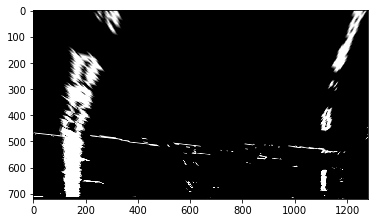

In [6]:
# image_process() it takes images and make combined threhold between sobelx, s_channel ,magnitude binary ,diretion ,binary
#and l_channel

%matplotlib inline
def image_process(img):
    img = cv2.imread(img)
    img = cal_undistort2(img)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = corners_unwarp(img)
    grad_binary_X = abs_sobel_thresh(img, 'x', thresh_min=40, thresh_max=120)
    grad_binary_X2 = abs_sobel_thresh(img, 'x', thresh_min=20, thresh_max=120)

    grad_binary_Y = abs_sobel_thresh(img, 'y', thresh_min=50, thresh_max=120)
    mag_binary = mag_thresh(img, sobel_kernel=15, mag_thresh=(90,180))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    dir_binary2 = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

    s_hls  = hls_select(img, thresh=(120, 255))
    s_hls2 = hls_select(img,thresh=(120, 255))
    s_hls3 = hls_select(img,thresh=(20, 255))
    l_hls  = l_select(img,thresh=(120,255))

    l_hls2 = l_select(img,thresh=(80,255))
    l_hls3  = l_select(img,thresh=(187,255))
    l_hls4  = l_select(img,thresh=(120,255))
    
    yellow_lines = select_yellow(img)
    yellow_lines2 = select_yellow2(img)
    white_lines = select_white(img)
    
    combined = np.zeros_like(dir_binary)
    combined[((s_hls== 1)&(l_hls == 1))|(((grad_binary_X2 == 1)&(dir_binary == 1)))|(((grad_binary_X2 == 1)&(l_hls2 == 1)))|(((l_hls2 == 1)&(mag_binary == 1)))|(((l_hls2 == 1)&(grad_binary_Y == 1))) ] = 1 
    combined = corners_unwarp(combined)
    plt.imshow(combined, cmap='gray')
    return combined
img = 'test_images/error4.png'
#img = 'test_images/straight_lines1.jpg'
img = 'test_images/test5.jpg'

combined2 = image_process(img)

In [7]:
global window_width, window_height ,margin
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 30 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

# find_window_centroids() function takes image and width and height of the window that define the rectangle that will cover the 
#lane line and the margin is the how the rectangle will move left or right according to lane lines
#this function will detect the lane lines and return two array of left and right lane lines
def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(combined[int(3*combined.shape[0]/4):,:int(combined.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(combined[int(3*combined.shape[0]/4):,int(combined.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(combined.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(combined.shape[0]/window_height)):
         # convolve the window into the vertical slice of the image
        image_layer = np.sum(combined[int(combined.shape[0]-(level+1)*window_height):int(combined.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,combined.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,combined.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
         # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    #return window_centroids
    left_line = []
    right_line = []
    left = []
    right = []
    for i in window_centroids:
        left_line.append(i[0])
        right_line.append(i[1])
    if len(window_centroids) > 0:
        l_points = np.zeros_like(combined)
        r_points = np.zeros_like(combined)
        for level in range(0,len(window_centroids)):
            right.append(window_centroids[level][1])
            left.append(window_centroids[level][0])
            l_mask = window_mask(window_width,window_height,combined,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,combined,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255 
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((combined,combined,combined)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage,1, template,0.5,0.0) # overlay the orignal road image with window results
        plt.imshow(output)
    else:
        output = np.array(cv2.merge((combined,combined,combined)),np.uint8)

    return left,right


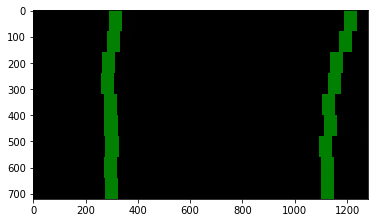

In [8]:

#combined = image_process_old('test_images/error4.png')
combined = image_process('test_images/test4.jpg')

k=find_window_centroids(combined, window_width, window_height, 50)

In [9]:
#road_lines() it take images from video and return final result of detected lane lines and the radius and the position of the vechiel 
def road_lines(img):
# here I convert the image to binary form with combinded threhold  
    global combined 
    img = cal_undistort2(img)
    combined = video_process(img)
    #combined = video_process(img)
# here I detect the lane lines
    left,right = find_window_centroids(combined, window_width, window_height, margin)

#ploty = range(0,combined.shape[0])
# I begin to poly fit the two lines with second degree polynominal equation
    ploty = np.linspace(0, 719, 720)
    res_yvals = np.arange(combined.shape[0]-(window_height/2),0,-window_height)

    out_img = np.dstack((combined, combined, combined))*255

    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.dstack((combined, combined, combined))*255
    left_fit = np.polyfit(res_yvals, left, 2)
    right_fit = np.polyfit(res_yvals, right, 2)
    left_fitx = left_fit[0]*ploty*ploty + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty*ploty + right_fit[1]*ploty + right_fit[2]
    left =np.array(left)
    right = np.array(right)
    
# this part is to calculate the radius I perfered to calculate the raduis of the center between the left and right line
 
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(res_yvals*ym_per_pix, left*xm_per_pix, 2)
    right_fit_cr = np.polyfit(res_yvals*ym_per_pix, right*xm_per_pix, 2)
# Calculate the new radi of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# the average between left line and the right line radii
    curv = (left_curverad + right_curverad)/2
# here I calculate the vechile position according to center
    center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (center-combined.shape[1]/2)*xm_per_pix
# here I defined where I am moving in the left or the right 
    postion = 'left'
    if center_diff <= 0:
        postion= 'right'

# here I detemine and visualize the lane lines 
    
    out_img = np.dstack((combined, combined, combined))*255
    window_img = np.zeros_like(out_img)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    

#I use Minv inverse to return the original image but with the detected lane line and I visualize it 
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
# put radius and position on the top of the image   
    cv2.putText(result,'postion = '+str(center_diff )+'m'+' '+postion,(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,'Raduis = '+str(curv)+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)


    return result

1015.33380936 m 1826.51802167 m


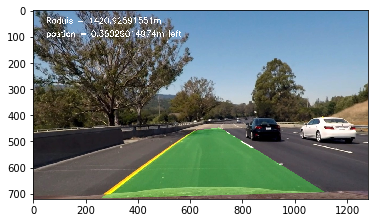

In [15]:
# this code cell do the same thing for the road_line() function but for single images
img = 'test_images/test6.jpg'
#img = 'test_images/error4.png'

# here I convert the image to binary form with combinded threhold  
combined = image_process('test_images/test6.jpg')
# here I detect the lane lines
left,right = find_window_centroids(combined, window_width, window_height, margin)

# I begin to poly fit the two lines with second degree polynominal equation
ploty = np.linspace(0, 719, 720)
res_yvals = np.arange(combined.shape[0]-(window_height/2),0,-window_height)

out_img = np.dstack((combined, combined, combined))*255

nonzero = combined.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img = np.dstack((combined, combined, combined))*255
# Fit a second order polynomial to each
left_fit = np.polyfit(res_yvals, left, 2)
right_fit = np.polyfit(res_yvals, right, 2)


# Generate x and y values for plotting
#ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
left_fitx = left_fit[0]*ploty*ploty + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty*ploty + right_fit[1]*ploty + right_fit[2]

left =np.array(left)
right = np.array(right)

# this part is to calculate the radius I perfered to calculate the raduis of the center between the left and right line
y_eval = np.max(ploty)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space

left_fit_cr = np.polyfit(res_yvals*ym_per_pix, left*xm_per_pix, 2)
right_fit_cr = np.polyfit(res_yvals*ym_per_pix, right*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


# here I calculate the vechile position according to center
center = (left_fitx[-1] + right_fitx[-1])/2
center_diff = (center-combined.shape[1]/2)*xm_per_pix
# here I defined where I am moving in the left or the right 
postion = 'left'
if center_diff <= 0:
    postion= 'right'




out_img = np.dstack((combined, combined, combined))*255
window_img = np.zeros_like(out_img)
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
img = cv2.imread(img)
img = cal_undistort2(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
warp_zero = np.zeros_like(combined).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

# the average between left line and the right line radii
curv = (left_curverad + right_curverad)/2
cv2.putText(result,'Raduis = '+str(curv)+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2.putText(result,'postion = '+str(center_diff )+'m'+' '+postion,(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

# put radius and position on the top of the image   

plt.imshow(result)


[MoviePy] >>>> Building video output_videos/video_project222.mp4
[MoviePy] Writing video output_videos/video_project222.mp4


 99%|███████████████████████████████████████▋| 125/126 [02:17<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/video_project222.mp4 

Wall time: 2min 19s


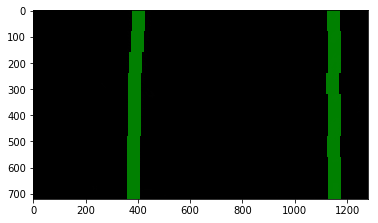

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#white_output = 'output_videos/video_process_4.mp4'
white_output = 'output_videos/video_project222.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are   values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_images/project_video.mp4").subclip(45,50)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(road_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)